In [229]:
import yfinance as yf
import numpy as np
import pandas as pd
import wikipedia as wp
import matplotlib.pyplot as plt
import os

# Data collection
The first step of the project is to collect the S&P100 stocks and their historical values. The S&P100 is a stock market index made up of 100 major companies in the United States that are listed on the NYSE or NASDAQ. The index is a subset of the S&P 500 and is used as a benchmark for the US stock market. 

## S&P100 stocks
The Wikipedia page is used to retrieve the S&P100 stocks list.
Notes:
- Alphabet Inc. (Google) is listed twice in the table due to the two different classes of shares. GOOGL is kept, as the oldest class of shares, and GOOG is deleted.
- Berkshire Hathaway is listed as BRK-B on yahoo! finance, while being listed BRK.B on the wikipedia page. The symbol is changed in this list to the yfinance value.

In [230]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe,Information Technology


In [231]:
stocks.to_csv("../data/S&P100/raw/stocks.csv")

## Historical values
The historical values of the stocks will be obtained using the yfinance library. The values for the last 3 years will be retrieved. Multi-level indexing is employed to store the historical values for each stock, indexing by Symbol and Date. 
The prices are transformed as variations instead of the price values to ensure consistent data throughout the dataset. The daily variations, as well as the High and Low variation in comparison to the open price, are kept. This value can give indications about the volatility of a stock. The volume is also normalized over the entire dataset.

In [232]:
values = [
	yf.Ticker(stock).history(period="3y")
	for stock in stocks.index
]
volumes = np.array([stock_values["Volume"] for stock_values in values]).flatten()
for stock_values in values:
	stock_values["Variation"] = (stock_values["Close"] / stock_values["Open"]) - 1
	stock_values["High"] = (stock_values["High"] / stock_values["Open"]) - 1
	stock_values["Low"] = (stock_values["Low"] / stock_values["Open"]) - 1
	stock_values["Volume"] = (stock_values["Volume"] - np.mean(volumes)) / np.std(volumes)
	stock_values.drop(columns=["Dividends", "Stock Splits", "Open", "Close"], inplace=True)
values = pd.concat(values, keys=stocks.index)
values.head()

High       Low    Volume  Variation
Symbol Date                                                              
AAPL   2021-04-27 00:00:00-04:00  0.002963 -0.006666  2.638796  -0.004592
       2021-04-28 00:00:00-04:00  0.005286 -0.009158  4.699780  -0.005435
       2021-04-29 00:00:00-04:00  0.004397 -0.029457  6.839592  -0.021910
       2021-04-30 00:00:00-04:00  0.013507 -0.005388  4.802444  -0.002428
       2021-05-03 00:00:00-04:00  0.015374 -0.001590  3.089031   0.003787

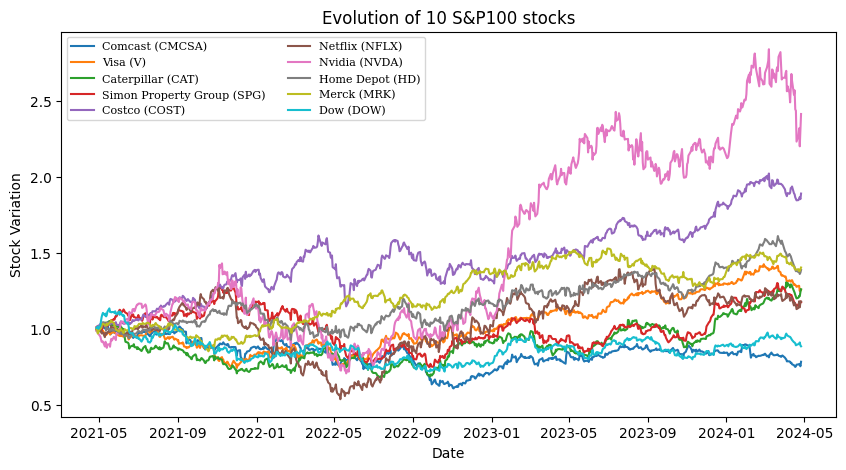

In [282]:
plt.figure(figsize=(10, 5))
n_random_stocks = 10
for stock in np.random.choice(stocks.index, size=n_random_stocks, replace=False):
	curr = 1
	plt.plot(values.loc[stock].index, [(curr := curr * (1 + v)) for v in values.loc[stock]["Variation"]], label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of {n_random_stocks} S&P100 stocks")
plt.xlabel('Date')
plt.ylabel('Stock Variation')
plt.legend(ncol=2, loc="upper left", prop={'size': 8, 'family': 'serif'})
plt.show()

In [276]:
values.to_csv("../data/S&P100/raw/values.csv")